# Causal Inference: The Mixtape Book Club

In [57]:
import daft
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm 
import statsmodels.formula.api as smf

## Goals of this notebook
1. Write out all terms such as collider etc
2. Create examples in daft of each (optional)
3. Simulate each
  * Show a correct regression
  * Show an incorrect regression

## Glossary

### Direct effect

<Axes:>

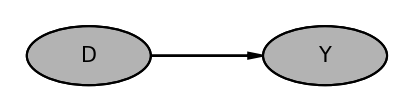

In [15]:
pgm = daft.PGM(aspect=2.1, dpi=150)
pgm.add_node("D","D", 3.0, 3.0,  observed=True)
pgm.add_node("Y","Y",  5.0, 3.0, observed=True)
pgm.add_edge("D", "Y")
pgm.render()

### Mediated effect

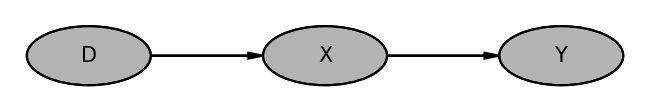

In [27]:
pgm = daft.PGM(aspect=2.1, dpi=150)
pgm.add_node("D","D", 3.0, 3.0, observed=True)
pgm.add_node("X","X",  5.0, 3.0, observed=True)
pgm.add_node("Y","Y",  7.0, 3.0, observed=True)
pgm.add_edge("D", "X")
pgm.add_edge("X", "Y")

pgm.render();

### Confounder
To close a backdoor path always condition on the cofounder

<Axes:>

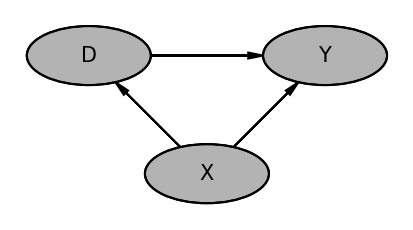

In [19]:
pgm = daft.PGM(aspect=2.1, dpi=150)
pgm.add_node("D","D", 0, 0, observed=True)
pgm.add_node("X","X",  1, -1, observed=True)
pgm.add_node("Y","Y",  2, 0, observed=True)
pgm.add_edge("D", "Y")
pgm.add_edge("X", "D")
pgm.add_edge("X", "Y")


pgm.render()

#### Example

In [252]:
def confounder(size):
    """Create a confounder example"""
    
    # Is confounder additive or multiplicative
    np.random.seed(100)
    unit_normal = stats.norm(0,1)
    x = unit_normal.rvs(size)
    d = (unit_normal.rvs(size))
    
    # For some reason need to add the coefficient here
    y = 3.56*d + 6.789*x + 21.123
    
    cofounder_df = pd.DataFrame({"x":x, "d":d, "y":y})
    return cofounder_df

confounder_df = confounder(1000)
mod = smf.ols(formula='y ~ d+x', data=confounder_df)
res = mod.fit()
res.params

Intercept    21.123
d             3.560
x             6.789
dtype: float64

#### Without conditioning on confounder

In [152]:
mod = smf.ols(formula='y ~ d', data=confounder_df)
res = mod.fit()
res.params

Intercept    21.017266
d             7.132388
dtype: float64

In [153]:
mod = smf.ols(formula='y ~ d+x', data=confounder_df)
res = mod.fit()
res.params

Intercept    21.123
d             3.567
x             6.789
dtype: float64

### Collider

<Axes:>

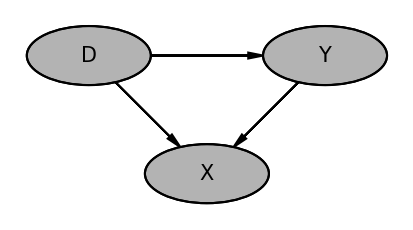

In [154]:
pgm = daft.PGM(aspect=2.1, dpi=150)
pgm.add_node("D","D", 0, 0, observed=True)
pgm.add_node("X","X",  1, -1, observed=True)
pgm.add_node("Y","Y",  2, 0, observed=True)
pgm.add_edge("D", "Y")
pgm.add_edge("D", "X")
pgm.add_edge("Y", "X")


pgm.render()

In [253]:
def collider(size):
    """Create a collider example"""
    
    # Is confounder additive or multiplicative
    unit_normal = stats.norm(0,1)
    x = unit_normal.rvs(size)
    d = unit_normal.rvs(size) 
    
    # For some reason need to add the coefficient here
    y = 3.567*d  + 21.123
    
    x = 3.567*d + y
    
    collider_df = pd.DataFrame({"x":x, "d":d, "y":y})
    return collider_df

collider_df = collider(1000)

#### Without conditioning on collider
Coefficient is correct

In [258]:
mod = smf.ols(formula='y ~ d', data=collider_df)
res = mod.fit()
res.params

Intercept    21.123
d             3.567
dtype: float64

#### With conditioning on collider
Causes issues

In [259]:
mod = smf.ols(formula='y ~ d+x', data=collider_df)
res = mod.fit()
res.params

Intercept    1.121597
d           -3.188196
x            0.946902
dtype: float64

### Collider and Confounder



<Axes:>

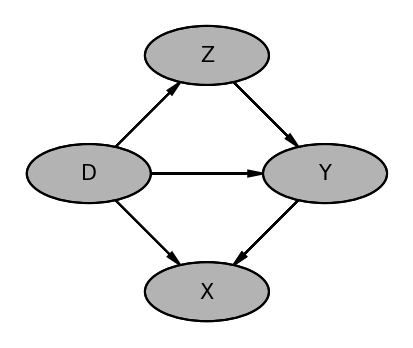

In [261]:
pgm = daft.PGM(aspect=2.1, dpi=150)

pgm.add_node("Z","Z", 1, 1, observed=True)
pgm.add_node("D","D", 0, 0, observed=True)
pgm.add_node("X","X",  1, -1, observed=True)
pgm.add_node("Y","Y",  2, 0, observed=True)

# Confounder
pgm.add_edge("D", "Z")
pgm.add_edge("Z", "Y")
pgm.add_edge("Y", "X")

# Collider
pgm.add_edge("D", "Y")
pgm.add_edge("D", "X")
pgm.add_edge("Y", "X")


pgm.render()